# Positional Encodingを理解したい！
作成日：2023/05/10 (修正・追加) <br>
作　成：Taiga MASUDA

# 目的
本 JupyterNotebook では，Transformer で用いられる Positional Encoding について理解を深める．<br>
本 JupyterNotebook で用いるライブラリ，モジュールを以下にまとめておく．また，本プログラムの実行環境を以下にまとめる．<br>
Python == 3.8.10 <br>
torch == 2.0.0 <br>
matplotlib == 3.7.1 <br>

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from matplotlib import animation

# Positional Encoding について
Self-Attention では，入力シーケンス内の各要素に対して，その要素と他の要素の関連度を計算することにより，重要な情報を抽出している．しかし，入力シーケンス内の各要素がどの位置になるのかを考慮しないまま Self-Attention を適用すると，シーケンスの順序情報が失われる可能性がある．そこで，Transformer では，位置情報を示す値を入力シーケンス内の各要素に位置情報を付与する．位置情報を示す値は，正弦波と余弦波を用いた関数で表現され，位置情報に応じて変化する値を取るようになっている．Positional Encoding の位置情報$PE$の式を以下に示す．

$PE_{(pos,2i)}=\sin\left(\frac{pos}{10000^{\frac{2i}{d_{\mathrm{model}}}}}\right)$

$PE_{(pos,2i+1)}=\cos\left(\frac{pos}{10000^{\frac{2i}{d_{\mathrm{model}}}}}\right)$

ここで，$pos$は単語の位置，$i$は次元，$d_{model}$は単語の埋め込み次元数を表す．

# 関数を実装
上記に示した式を実際に実装し，挙動を確認する．

In [2]:
max_seq_len = 128 # 文字列の最大長を定義
d_model = 512 # 各単語の分散表現の次元数を定義

pe = torch.zeros(max_seq_len, d_model) # Positional Encoding の値を格納しておく配列を作成

# 各要素に Psitional Encoding の数式を適用した値を格納
for pos in range(max_seq_len):
        for i in range(d_model//2):
            pe[pos, 2*i] = math.sin(pos / (10000 ** ((2*i)/d_model)))
            pe[pos, 2*i+1] = math.cos(pos / (10000 ** ((2*i)/d_model)))

# Positional Encoding の可視化
上記コードで作成した Positional Encoding の各要素を以下で可視化する．

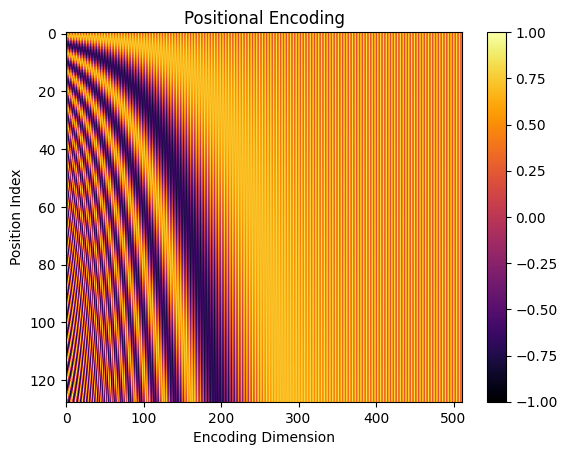

In [3]:
im = plt.imshow(pe, cmap='inferno', aspect='auto')
plt.colorbar(im)
plt.title("Positional Encoding")
plt.xlabel("Encoding Dimension")
plt.ylabel("Position Index")
plt.savefig('position_emcoding.svg')
plt.savefig('position_emcoding.pdf')
plt.show()

ここで，<br>
$\left(\frac{pos}{10000^{\frac{2i}{d_{\mathrm{model}}}}}\right)$
の値が<br>どのように変化するのかを，確認するために，あるposにおいて，2iの値の変化における，単位円上での変化を可視化してみることとする．<br>
※jupyter notebook上では，以下のプログラムでは，表示されない．保存された，動画ファイルで確認できる．


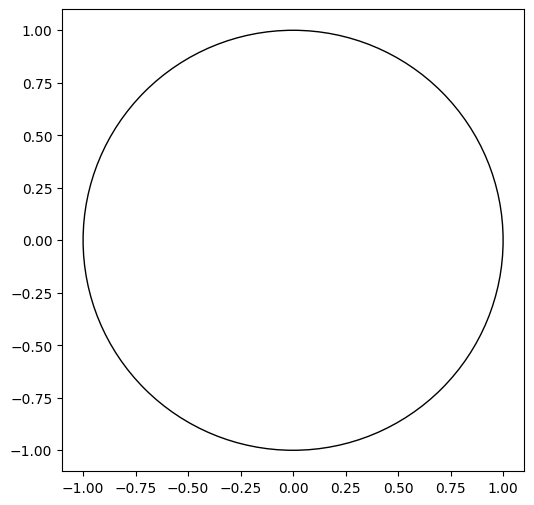

In [4]:
def positional_encoding_angle(pos, i, d):
    angle = pos / np.power(10000, 2 * i / d)
    return angle

d = 512  # 位置情報ベクトルの次元数
pos = 0  # 指定した位置

i_values = np.arange(d)  # 0からd//2までの値を生成
angles = positional_encoding_angle(pos, i_values, d)

angles_rad = angles * (2 * np.pi)  # ラジアンに変換

x = np.cos(angles_rad)  # x座標
y = np.sin(angles_rad)  # y座標

fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, fill=False, color='black')
ax.add_patch(circle)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
angle_line, = ax.plot([], [], lw=2)

i_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    angle_line.set_data([], [])
    i_text.set_text('')
    return angle_line, i_text

def animate(i):
    angle_line.set_data([0, x[i]], [0, y[i]])
    i_text.set_text('2i : {}'.format(i_values[i]))
    ax.set_title('pos / 10000**(2*i/d)   pos={}'.format(pos))
    return angle_line, i_text

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(i_values), interval=200, blit=True)
#ani.save('pe_animation.mp4', writer='ffmpeg', fps=20)
#plt.show()

さらに，Position Index (単語の位置) = 1, 20, 50 でのPositional Encoding の値を見てみることとする．


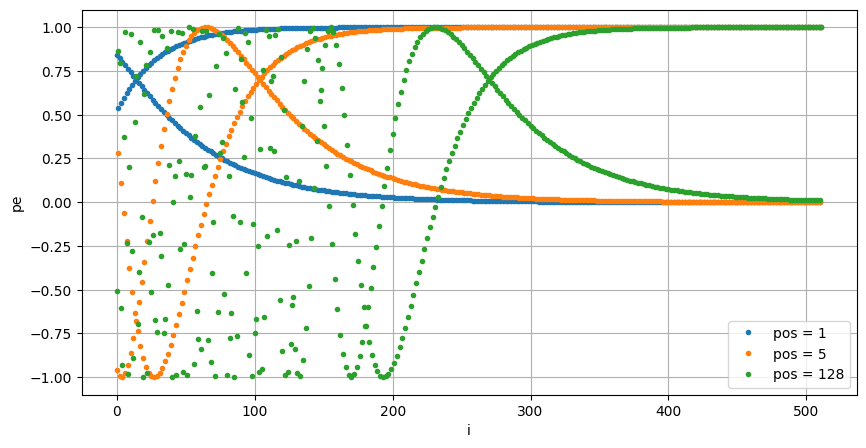

In [5]:
plt.figure(figsize=[10,5])
plt.plot(pe[1].numpy(),'.', label='pos = 1')
plt.plot(pe[5].numpy(),'.', label='pos = 5')
#plt.plot(pe[10].numpy(),'.', label='pos = 10')
#plt.plot(pe[50].numpy(),'.', label='pos = 50')
plt.plot(pe[100].numpy(),'.', label='pos = 128')
plt.xlabel("i")
plt.ylabel("pe")
plt.grid()
plt.legend()
plt.savefig('position.svg')
plt.savefig('position.pdf')
plt.show()

以上より，Position Index (単語の位置) が大きくなるにつれて，Encodingベクトルで，0と1が交互に現れる回数が少なくなることが確認でき，単語の位置が大きくなるほど高周波数の波形が足されることが確認できる．

# Positional Encoding class の作成
最後に，Positional Encoding を行うクラスを以下に作成する．<br>
★単純に Positional Encoding の値を単語の分散表現ベクトルに加算しただけでは，単語の分散表現情報が失われてしまう恐れがある．そのため，入力の単語の分散表現ベクトルの値を増やして，単語の分散表現ベクトルが後続層で効率的に使われるようにする必要がある．その方法として，$sqrt(d_{model})$ の値を加える．

In [6]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=512, max_seq_len=128):
        super().__init__()

        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)

        for pos in range(max_seq_len):
            for i in range(d_model//2):
                pe[pos, 2*i] = math.sin(pos / ((10000 ** ((2*i)/d_model))))
                pe[pos, 2*i+1] = math.cos(pos / ((10000 ** ((2*i)/d_model))))

        # バッチ処理を可能にするために，入力データと同じ形状にする
        self.pe = pe.unsqueeze(0)

        # 学習しないための設定
        self.pe.requires_grad = False

    def forward(self, x):
        r = math.sqrt(self.d_model)*x # ★
        ret = r + self.pe
        return ret

以下テスト

In [7]:
# 疑似入力データとして，batch_size=24, max_length=128, d_model=512のデータを作成する
x = torch.randn(24,128,512)

model = PositionalEncoder()
y = model(x)

r = math.sqrt(model.d_model)*x
print('入力データの形状：', x.shape)
print('出力データの形状：', y.shape)
print('入力データの例：', x[0][0][:4])
print('入力データの例：', r[0][0][:4], '※スケーリングされた入力データ')
print('  pe  の値の例：', model.pe[0][0][:4])
print('出力データの例：', y[0][0][:4])


入力データの形状： torch.Size([24, 128, 512])
出力データの形状： torch.Size([24, 128, 512])
入力データの例： tensor([ 0.1157, -0.2615,  0.1104,  0.7274])
入力データの例： tensor([ 2.6181, -5.9177,  2.4982, 16.4602]) ※スケーリングされた入力データ
  pe  の値の例： tensor([0., 1., 0., 1.])
出力データの例： tensor([ 2.6181, -4.9177,  2.4982, 17.4602])


=====================================================<br>間違った記述がありましたら，教えてください！<br>
作成日：2023/05/10<br>
作　成：Taiga MASUDA